<a href="https://colab.research.google.com/github/AashirA1/Project/blob/main/cat_v_Dog_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://www.kaggle.com/datasets/salader/dogsvscats/data

--2025-11-12 08:36:32--  https://www.kaggle.com/datasets/salader/dogsvscats/data
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data’

data                    [ <=>                ]   8.67K  --.-KB/s    in 0.01s   

2025-11-12 08:36:32 (821 KB/s) - ‘data’ saved [8881]



First, you'll need to install the Kaggle library.

In [2]:
!pip install kaggle

Next, you need to upload your Kaggle API key (`kaggle.json`) to your Colab environment. You can get this file from your Kaggle account settings.

In [3]:
from google.colab import files
files.upload()  # kaggle.json select karo


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aashirasad","key":"d8617126984dcd6a2dd40906353806cb"}'}

Once you have uploaded the `kaggle.json` file, move it to the correct directory and set the appropriate permissions.

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Now you can download the dataset using the Kaggle API command. You can find the dataset's API command on the dataset page under the '...' menu. For example, the command for the `salader/dogsvscats` dataset is `kaggle datasets download -d salader/dogsvscats`.

In [5]:
!kaggle datasets download -d salader/dogsvscats

Dataset URL: https://www.kaggle.com/datasets/salader/dogsvscats
License(s): unknown
 99% 1.06G/1.06G [00:05<00:00, 189MB/s]
100% 1.06G/1.06G [00:05<00:00, 196MB/s]


Finally, you might need to unzip the downloaded dataset.

In [6]:
import zipfile
import os

for file in os.listdir():
    if file.endswith('.zip'):
        zip_ref = zipfile.ZipFile(file, 'r')
        zip_ref.extractall()
        zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Mixed Precision for Speed on T4 GPU ✅
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
IMAGE_SIZE = (180, 180)
BATCH_SIZE = 64

train_ds = keras.utils.image_dataset_from_directory(
    "/content/train",
    validation_split=0.2,
    subset="training",
    seed=42,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True
)
train_class_names = train_ds.class_names # Store class names here

validation_ds = keras.utils.image_dataset_from_directory(
    "/content/train",
    validation_split=0.2,
    subset="validation",
    seed=42,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True
)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)
validation_ds = validation_ds.prefetch(AUTOTUNE)


In [11]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=IMAGE_SIZE + (3,)),

    layers.Conv2D(32, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.4),

    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(1, activation="sigmoid", dtype='float32') # fix float mismatch
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356,033 (16.62 MB)

 Trainable params: 4,354,817 (16.61 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [13]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1

)
lr_reduce  = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=30,
    validation_data=validation_ds,
    callbacks=[early_stop, lr_reduce]
)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 531ms/step - accuracy: 0.6295 - loss: 0.7732 - val_accuracy: 0.5088 - val_loss: 0.9182 - learning_rate: 0.0010
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 132s 526ms/step - accuracy: 0.7435 - loss: 0.5303 - val_accuracy: 0.6672 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 127s 506ms/step - accuracy: 0.7731 - loss: 0.4708 - val_accuracy: 0.7673 - val_loss: 0.5182 - learning_rate: 0.0010
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 128s 511ms/step - accuracy: 0.8048 - loss: 0.4185 - val_accuracy: 0.8087 - val_loss: 0.4265 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 502ms/step - accuracy: 0.8352 - loss: 0.3703 - val_accuracy: 0.8350 - val_loss: 0.3715 - learning_rate: 0.0010
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 127s 506ms/step - accuracy: 0.8506 - loss: 0.3343 - val_accuracy: 0.8133 - val_loss: 0.4020 - learning_rate: 0.0010
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 126s 502ms/step - accura

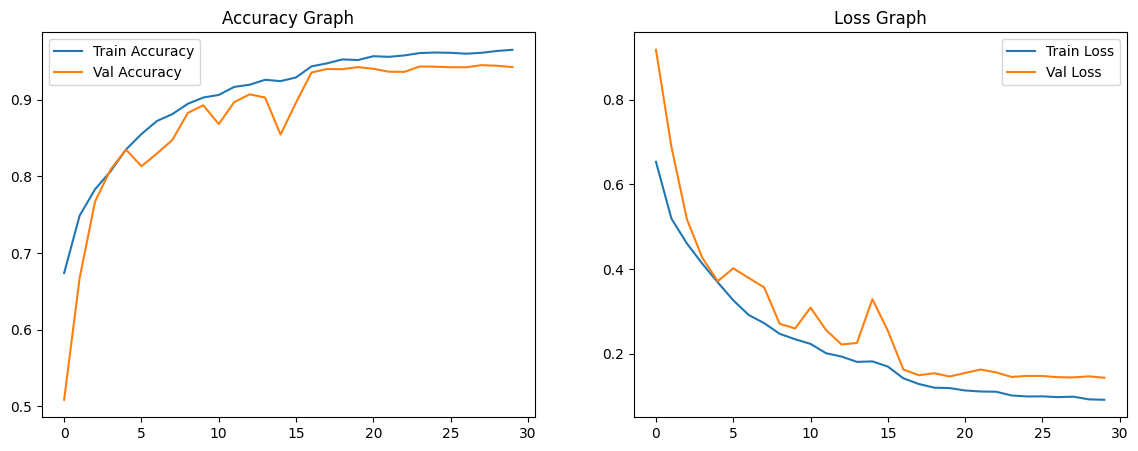

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.legend()
plt.title("Accuracy Graph")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.legend()
plt.title("Loss Graph")
plt.show()


In [15]:
model.save("CatsVsDogs_CNN_Optimized.h5")
print("✅ Model Saved Successfully!")


✅ Model Saved Successfully!


In [33]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix

# 🔹 Change these paths to your actual test directories
cat_dir = "/content/test/cats"
dog_dir = "/content/test/dogs"

# 🔹 Automatically detect class mapping from folder names
classes = sorted([os.path.basename(cat_dir), os.path.basename(dog_dir)])
class_indices = {classes[0]: 0, classes[1]: 1}
class_map = {v: k for k, v in class_indices.items()}
print("Auto-detected class mapping:", class_indices)

# 🔹 Read up to 1000 images (500 cats + 500 dogs for fairness)
X, y_true = [], []
for folder, label in [(cat_dir, class_indices[os.path.basename(cat_dir)]),
                      (dog_dir, class_indices[os.path.basename(dog_dir)])]:
    img_files = os.listdir(folder)[:500]
    for img_name in img_files:
        img_path = os.path.join(folder, img_name)
        try:
            img = image.load_img(img_path, target_size=(180, 180))
            x = image.img_to_array(img) / 255.0  # normalize
            X.append(x)
            y_true.append(label)
        except Exception as e:
            print(f"Skipping {img_name}: {e}")

X = np.array(X)
y_true = np.array(y_true)

print(f"✅ Loaded {len(X)} images successfully.")

# 🔹 Run model predictions
preds = model.predict(X, batch_size=32, verbose=1)
pred_classes = (preds > 0.5).astype(int).flatten()

# 🔹 Show metrics
cm = confusion_matrix(y_true, pred_classes)
report = classification_report(y_true, pred_classes, target_names=classes)

print("\nConfusion Matrix:\n", cm)
print("\nDetailed Classification Report:\n", report)


Auto-detected class mapping: {'cats': 0, 'dogs': 1}
✅ Loaded 1000 images successfully.
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Confusion Matrix:
 [[500   0]
 [500   0]]

Detailed Classification Report:
               precision    recall  f1-score   support

        cats       0.50      1.00      0.67       500
        dogs       0.00      0.00      0.00       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
